# MC Dropout with Fire Detection

## **1. Fire Detection Dataset 다운로드**

In [4]:
import os

os.system("kaggle datasets download atulyakumar98/test-dataset")
os.system("kaggle datasets download phylake1337/fire-dataset")
os.makedirs("data", exist_ok = True)
os.system("unzip -o test-dataset.zip -d ./data")
os.system("unzip -o fire-dataset.zip -d ./data")
os.system("rm test-dataset.zip")
os.system("rm fire-dataset.zip")

os.rename("data/fire_dataset/fire_images", "data/fire_dataset/1")
os.rename("data/fire_dataset/non_fire_images", "data/fire_dataset/0")

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/test-dataset
License(s): unknown


100%|██████████| 132M/132M [00:04<00:00, 33.1MB/s] 



Dataset URL: https://www.kaggle.com/datasets/phylake1337/fire-dataset
License(s): CC0-1.0


100%|██████████| 387M/387M [00:12<00:00, 31.7MB/s] 



Archive:  test-dataset.zip
  inflating: ./data/Fire-Detection/0/1.jpg  
  inflating: ./data/Fire-Detection/0/10.jpg  
  inflating: ./data/Fire-Detection/0/100.jpg  
  inflating: ./data/Fire-Detection/0/101.jpg  
  inflating: ./data/Fire-Detection/0/102.jpg  
  inflating: ./data/Fire-Detection/0/103.jpg  
  inflating: ./data/Fire-Detection/0/104.jpg  
  inflating: ./data/Fire-Detection/0/105.jpg  
  inflating: ./data/Fire-Detection/0/106.jpg  
  inflating: ./data/Fire-Detection/0/107.jpg  
  inflating: ./data/Fire-Detection/0/108.jpg  
  inflating: ./data/Fire-Detection/0/109.jpg  
  inflating: ./data/Fire-Detection/0/11.jpeg  
  inflating: ./data/Fire-Detection/0/110.jpg  
  inflating: ./data/Fire-Detection/0/111.jpg  
  inflating: ./data/Fire-Detection/0/112.jpg  
  inflating: ./data/Fire-Detection/0/113.jpg  
  inflating: ./data/Fire-Detection/0/114.jpg  
  inflating: ./data/Fire-Detection/0/115.jpg  
  inflating: ./data/Fire-Detection/0/116.jpg  
  inflating: ./data/Fire-Detection/

## **2. 훈련 데이터 분리 및 기초 통계량 확인**

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random

import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

`-` 시드 설정 (재현성 확보)

In [2]:
def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42

`-` 이미지 데이터셋

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        """
        root: 데이터셋 위치 폴더
        transform: torchvision.transforms.Compose 객체
        """
        self.root = root
        self.transform = transform
        self.classes = sorted(os.listdir(root))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for cls_name in self.classes:
            cls_path = os.path.join(root, cls_name)
            for img_name in os.listdir(cls_path):
                img_path = os.path.join(cls_path, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  

        if self.transform:
            image = self.transform(image)

        return image, label

fst_dir = 'data/fire_dataset'
snd_dir = 'data/Fire-Detection'

`-` Train/Test 데이터셋 분리 (8:2 stratified splitting)

In [4]:
tensor_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

fst_dataset = CustomImageDataset(root = fst_dir, transform = tensor_transform)
snd_dataset = CustomImageDataset(root = snd_dir, transform = tensor_transform)
full_dataset = fst_dataset + snd_dataset

labels = torch.tensor(fst_dataset.labels + snd_dataset.labels)
source_info = ["FIRE Dataset"]*len(fst_dataset) + ["Fire Detection Dataset"]*len(snd_dataset)

train_ds, test_ds, train_source, test_source = train_test_split(full_dataset, source_info, test_size = 0.2, stratify = labels, random_state = 42)

`-` RGB 채널 별 기초통계량 및 픽셀 수 관련 통계량 계산

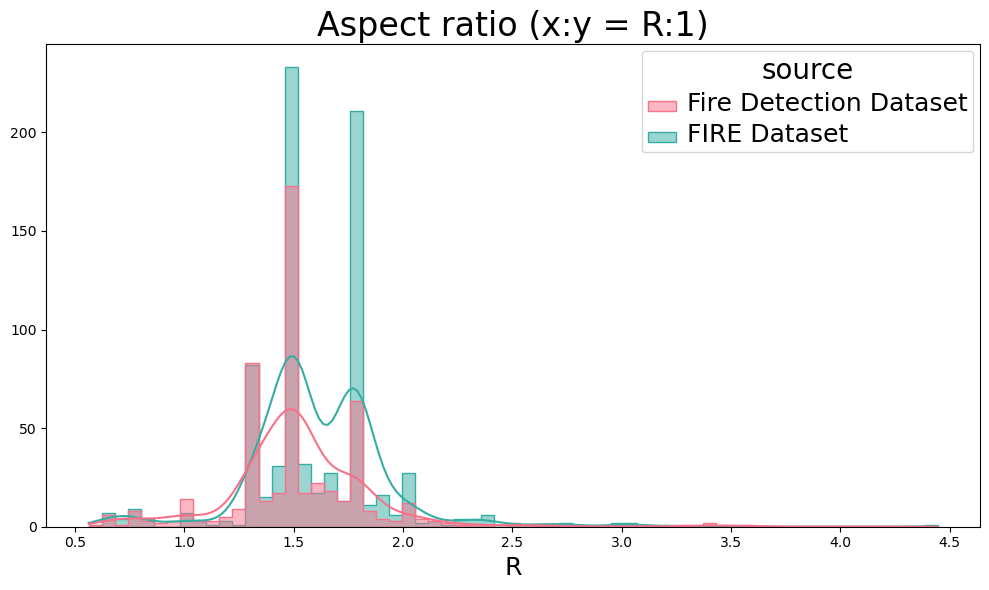

In [5]:
shape_list = [img[0].shape[1:] for img in train_ds]
y_axis, x_axis = torch.tensor(shape_list)[:, 0], torch.tensor(shape_list)[:, 1]
xy_ratio = x_axis/y_axis

palette = sns.color_palette("husl", 2)
tidy = pd.DataFrame({"R": xy_ratio, "source": train_source})

## 종횡비 시각화
plt.figure(figsize=(10, 6))
ax = sns.histplot(tidy, x = "R", hue = "source", kde = True, stat = "count",
                  common_norm=False, element="step", alpha = 0.5, palette = palette)
plt.title("Aspect ratio (x:y = R:1)", fontsize = 24)
plt.xlabel("R", fontsize = 18)
plt.ylabel(None)

plt.setp(ax.get_legend().get_texts(), fontsize=18) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title

plt.tight_layout()
plt.savefig("fig/aspect_ratio.png", dpi = 300)

> 가로가 긴 사진이 더 많긴 하지만, 균일하지 않음. 정사각형으로 리사이즈하는 게 나을 것 같음

최소 픽셀 수: 147


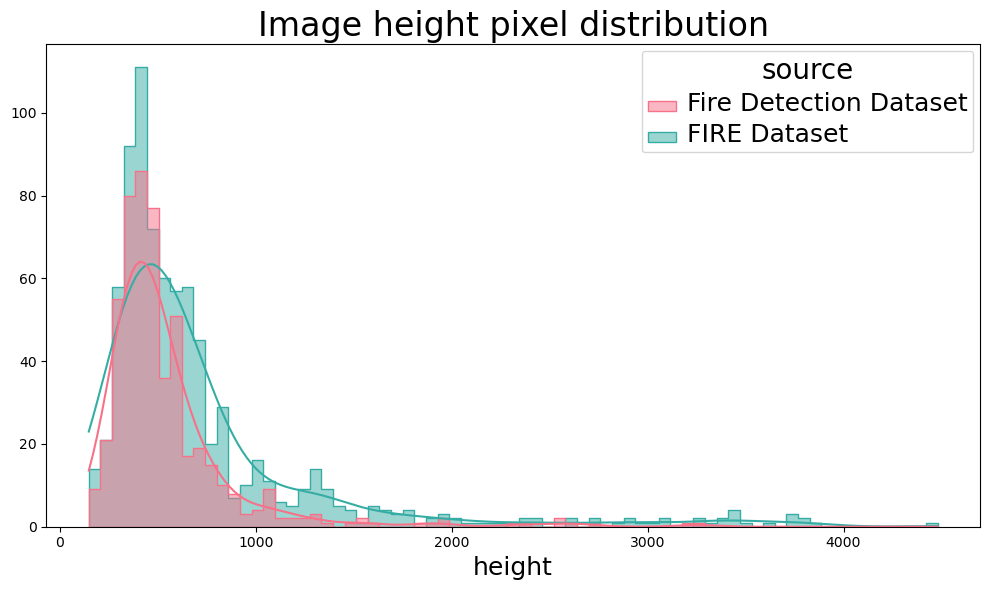

In [ ]:
## 픽셀 수 시각화
tidy = pd.DataFrame({"height": torch.tensor(shape_list)[:, 0],
                     "source": train_source})

palette = sns.color_palette("husl", 2)

plt.figure(figsize=(10, 6))
ax = sns.histplot(data = tidy, x = "height", hue = "source", kde = True, stat = "count",
             common_norm=False, element="step", alpha = 0.5, palette=palette)
plt.title("Image height pixel distribution", fontsize = 24)
plt.xlabel("height", fontsize = 18)
plt.ylabel(None)

plt.setp(ax.get_legend().get_texts(), fontsize=18) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title

plt.tight_layout()
plt.savefig("fig/height_distribution.png", dpi = 300)

min_pixel = torch.tensor(shape_list).min()

print(f"최소 픽셀 수: {min_pixel.int()}")

[R, G, B] channel mean: [0.442, 0.3569, 0.283]
[R, G, B] channel std: [0.2781, 0.2527, 0.2595]


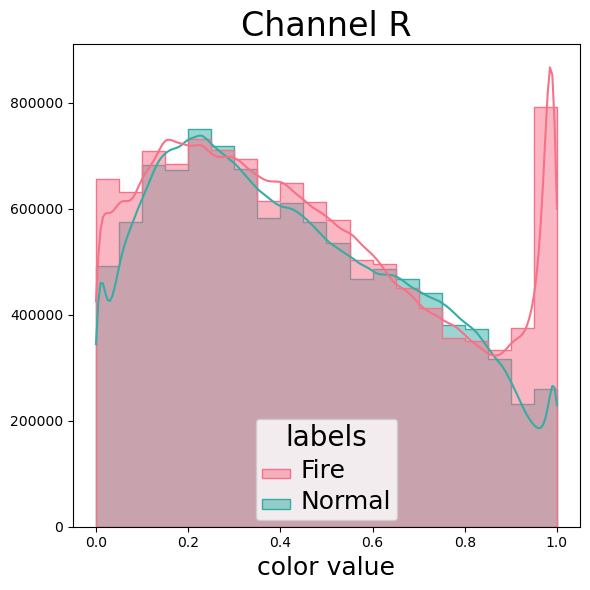

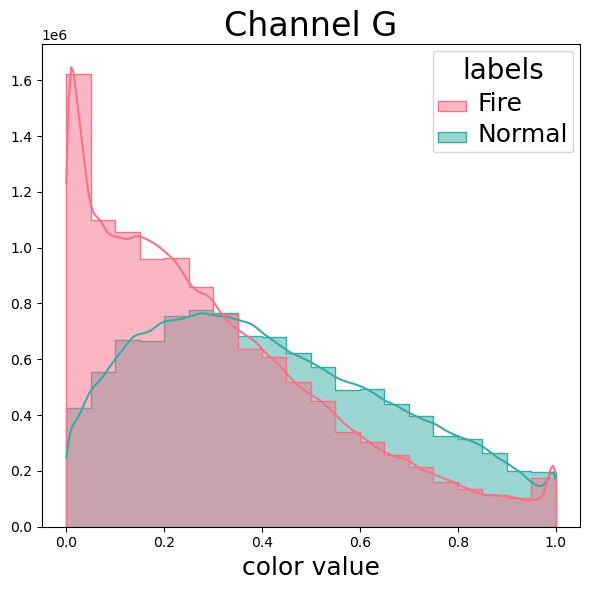

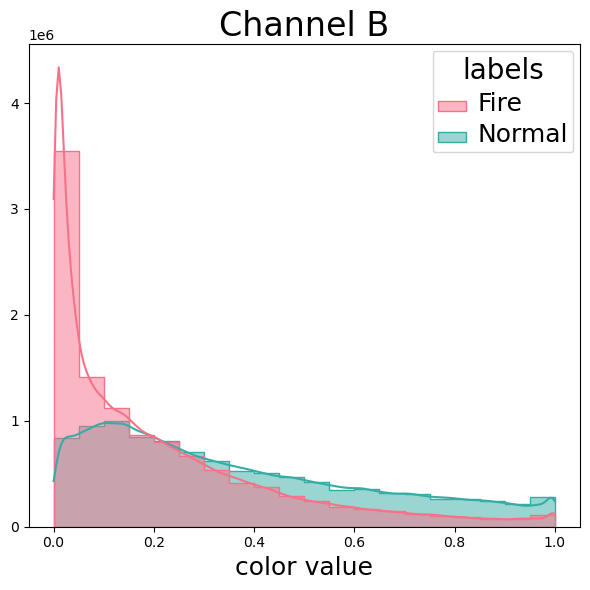

In [29]:
## 정사각형으로 리사이즈 후 RGB 값 추출
min_pixel = 128

tensor_transform = torchvision.transforms.Compose([
    transforms.Resize((min_pixel, min_pixel)),
    torchvision.transforms.ToTensor()
])

fst_dataset = CustomImageDataset(root = fst_dir, transform = tensor_transform)
snd_dataset = CustomImageDataset(root = snd_dir, transform = tensor_transform)
full_dataset = fst_dataset + snd_dataset

labels = torch.tensor(fst_dataset.labels + snd_dataset.labels)
source_info = ["FIRE Dataset"]*len(fst_dataset) + ["Fire Detection Dataset"]*len(snd_dataset)

train_ds, test_ds, train_label, test_label = train_test_split(full_dataset, labels, test_size = 0.2, stratify = labels, random_state = 42)

## 색상값 분포 (float)
origin_tensor = [img[0] for img in train_ds]

mean = []
std = []
channels = ["R", "G", "B"]

for i in range(3):
    c = []
    label = []

    for j, img in enumerate(origin_tensor):
        flat = img[i].flatten()
        c.append(flat)
        label.extend(["Fire" if train_label[j].item() else "Normal"]*len(flat))

    c = torch.concat(c)
    mean.append(c.mean().item())
    std.append(c.std().item())

    tidy = pd.DataFrame({"color value": c, "labels": label})
    tidy["labels"] = pd.Categorical(tidy["labels"], categories=["Fire", "Normal"], ordered=True)

    palette = sns.color_palette("husl", 2)

    plt.figure(figsize=(6, 6))
    ax = sns.histplot(data = tidy, x = "color value", hue = "labels", kde = True, stat = "count",
                      common_norm=False, element="step", alpha = 0.5, palette=palette, bins = 20)
    plt.title(f"Channel {channels[i]}", fontsize = 24)
    plt.xlabel("color value", fontsize = 18)
    plt.ylabel(None)

    plt.setp(ax.get_legend().get_texts(), fontsize=18) # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=20) # for legend title

    plt.tight_layout()
    plt.savefig(f"fig/color_value_{channels[i]}.png", dpi = 300)

print(f"[R, G, B] channel mean: {[round(m, 4) for m in mean]}")
print(f"[R, G, B] channel std: {[round(s, 4) for s in std]}")

`-` 데이터 전처리

In [4]:
mean = [0.4420, 0.3569, 0.2830]
std = [0.2781, 0.2527, 0.2595]
min_pixel = 128

## train dataset의 통계량으로 정규화하여 정보 유출 방지
transform = transforms.Compose([
    transforms.Resize((min_pixel, min_pixel)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std)
])

fst_dataset = CustomImageDataset(root = fst_dir, transform = transform)
snd_dataset = CustomImageDataset(root = snd_dir, transform = transform)
full_dataset = fst_dataset + snd_dataset

labels = torch.tensor(fst_dataset.labels + snd_dataset.labels)
class_counts = Counter(labels.tolist())
print('Class Distribution:', class_counts)

Class Distribution: Counter({1: 865, 0: 785})


`-` Train/Valid/Test 데이터셋 분리 (6:2:2 stratified splitting)

In [5]:
train_ds, test_ds, train_label, test_label = train_test_split(full_dataset, labels, test_size = 0.2, stratify = labels, random_state = 42)
train_ds, valid_ds, train_label, valid_label = train_test_split(train_ds, train_label, test_size = 0.25, stratify = train_label, random_state = 42)

In [6]:
print(f"Full dataset size: {len(full_dataset)}")
print(f"Train dataset size: {len(train_ds)}")
print(f"Valid dataset size: {len(valid_ds)}")
print(f"Test dataset size: {len(test_ds)}")

Full dataset size: 1650
Train dataset size: 990
Valid dataset size: 330
Test dataset size: 330


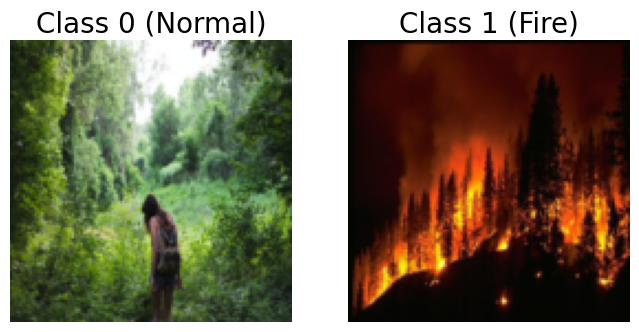

In [7]:
mean = [0.4420, 0.3569, 0.2830]
std = [0.2781, 0.2527, 0.2595]

# 첫 번째 이미지(정상)와 마지막 이미지(화재)꺼내서 보기
inv_normalize = transforms.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)

img_normal = inv_normalize(train_ds[1][0]).permute(1, 2, 0)
img_fire = inv_normalize(train_ds[0][0]).permute(1, 2, 0)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(img_normal)
ax[0].set_title("Class 0 (Normal)", fontsize = 20)
ax[1].imshow(img_fire)
ax[1].set_title("Class 1 (Fire)", fontsize = 20)

for i in range(2):
      ax[i].axis("off")

plt.savefig("fig/resized_img.png", dpi = 300)

## **3. Baseline CNN**

`-` 하이퍼 파라미터 세팅

In [8]:
BATCH_SIZE = 32
EPOCHS = 400
LEARNING_RATE = 5e-6
WEIGHT_DECAY = 0.005
PATIENCE = 30

`-` 데이터 로더 세팅

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = True)
valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size = BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size = BATCH_SIZE)

`-` CNN 네트워크 설계

In [34]:
device = torch.device("cuda:0")
seed_value = 14107
set_seed(seed_value)

## 네트워크 설계
net = torch.nn.Sequential(
    #[Layer 1] Input: 3 x 128 x 128
    torch.nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 64 x 42 x 42
    #[Layer 2]
    torch.nn.Conv2d(64, 256, kernel_size = 3, padding = 1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 256 x 14 x 14
    #[Layer 3]
    torch.nn.Conv2d(256, 512, kernel_size = 3, padding = 1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(kernel_size = 2), # -> 512 x 7 x 7
    #[Layer 4]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding = 1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d((1, 1)),  # -> 512 x 1

    torch.nn.Flatten(),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1)
).to(device)

Epoch 0 | train_loss: 0.5465	 valid_loss: 0.5796
Epoch 10 | train_loss: 0.2940	 valid_loss: 0.4840
Epoch 20 | train_loss: 0.2421	 valid_loss: 0.3973
Epoch 30 | train_loss: 0.1910	 valid_loss: 0.3763
Epoch 40 | train_loss: 0.1767	 valid_loss: 0.3615
Epoch 50 | train_loss: 0.1561	 valid_loss: 0.3255
Epoch 60 | train_loss: 0.1361	 valid_loss: 0.3143
Epoch 70 | train_loss: 0.1192	 valid_loss: 0.2907
Epoch 80 | train_loss: 0.1110	 valid_loss: 0.2849
Epoch 90 | train_loss: 0.1129	 valid_loss: 0.2693
Epoch 100 | train_loss: 0.0952	 valid_loss: 0.2778
Epoch 110 | train_loss: 0.0840	 valid_loss: 0.2737
Epoch 120 | train_loss: 0.0878	 valid_loss: 0.2501
Epoch 130 | train_loss: 0.0669	 valid_loss: 0.2418
Epoch 140 | train_loss: 0.0654	 valid_loss: 0.2617
Epoch 150 | train_loss: 0.0632	 valid_loss: 0.2624
Epoch 160 | train_loss: 0.0510	 valid_loss: 0.2410
Epoch 170 | train_loss: 0.0642	 valid_loss: 0.2371
========== Training Finished. Best Epoch: 145 ==========


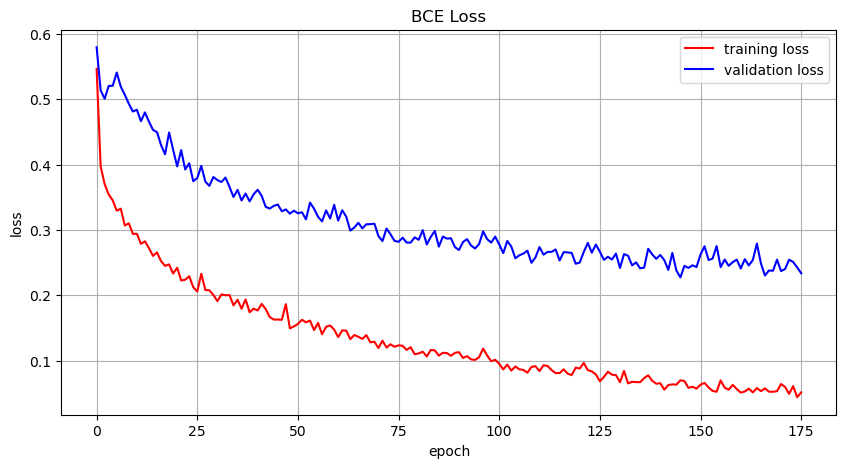

In [35]:
## 손실함수 및 옵티마이저
loss_fn = torch.nn.BCEWithLogitsLoss()
opt = torch.optim.AdamW(net.parameters(),
                        lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)

## 10번 valid_loss가 개선되지 않으면 lr을 현재의 절반으로 줄임
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)

## 학습
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
best_valid_loss = torch.inf
patience = 0
best_epoch = 0

for epoc in range(EPOCHS):
    net.train()
    s = 0
    train_loss = 0
    valid_loss = 0
    
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device).reshape(-1, 1).float()
        
        #업데이트
        netout = net(X)
        loss = loss_fn(netout, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() * X.size(0)
        s += ((netout > 0.0).squeeze() == y.squeeze()).sum()

    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = (s / len(train_dataloader.dataset)).item()

    net.eval()

    with torch.no_grad():
        s = 0

        for XX, yy in valid_dataloader:
            XX = XX.to(device)
            yy = yy.to(device).reshape(-1, 1).float()

            netout = net(XX)
            loss = loss_fn(netout, yy)
            valid_loss += loss.item() * XX.size(0)
            s += ((netout > 0.0).squeeze() == yy.squeeze()).sum()

        valid_loss = valid_loss / len(valid_dataloader.dataset)
        valid_acc = (s / len(valid_dataloader.dataset)).item()

        train_acc_history.append(avg_train_acc)
        train_loss_history.append(avg_train_loss)
        valid_acc_history.append(valid_acc)
        valid_loss_history.append(valid_loss)

    scheduler.step(valid_loss)

    if epoc % 10 == 0:
        print(f"Epoch {epoc} | train_loss: {avg_train_loss:.4f}\t valid_loss: {valid_loss:.4f}")

    # Best Model 저장
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_epoch = epoc
        torch.save(net.state_dict(), 'baseline_best.pth')
        patience = 0

    else:
        patience += 1

        if patience >= PATIENCE:
            break

print(f"========== Training Finished. Best Epoch: {best_epoch} ==========")

## 결과 확인
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='training loss', color='red')
plt.plot(valid_loss_history, label='validation loss', color='blue')
plt.title("BCE Loss")
plt.xlabel("epoch") 
plt.ylabel("loss")
plt.grid(True)
plt.legend()
plt.savefig("fig/loss_flow.png", dpi = 300)

In [36]:
## 테스트 데이터셋 정확도 확인
net.load_state_dict(torch.load("baseline_best.pth", weights_only=True))

net.eval()
yhat = []

with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)
        
        netout = net(X)
        yhat.append(torch.sigmoid(netout))

    yhat = torch.concat(yhat, axis = 0).squeeze().to("cpu")

pd.DataFrame({"True": test_label, "Pred": yhat}).to_csv("result/Baseline_result.csv", index = False, encoding = "utf-8-sig")
test_acc = ((yhat > 0.5) == test_label).float().mean().item()

print(f"\n테스트 정확도: {test_acc:.4f}")


테스트 정확도: 0.9394


* 현재 점수: 0.9394 (14107 seed)
* 최대 점수: 0.9845 <- 6 레이어. 모델을 조금 더 가볍게 해야...

## **4. MC dropout**

In [10]:
NUM_MC_SAMPLES = 100

In [11]:
device = torch.device("cuda:0")

## 네트워크 설계
net = torch.nn.Sequential(
    #[Layer 1] Input: 3 x 180 x 180
    torch.nn.Conv2d(3, 64, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 64 x 60 x 60
    #[Layer 2]
    torch.nn.Conv2d(64, 256, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(kernel_size = 3), # -> 256 x 20 x 20
    #[Layer 3]
    torch.nn.Conv2d(256, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.MaxPool2d(kernel_size = 2), # -> 512 x 10 x 10
    #[Layer 4]
    torch.nn.Conv2d(512, 512, kernel_size = 3, padding=1),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d((1, 1)),  # -> 512 x 1

    torch.nn.Flatten(),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 1)
).to(device)

net.load_state_dict(torch.load("baseline_best.pth", weights_only=True))

<All keys matched successfully>

In [15]:
# Source - https://stackoverflow.com/a
# Posted by Iswariya Manivannan, modified by community. See post 'Timeline' for change history
# Retrieved 2025-12-09, License - CC BY-SA 4.0

import sys

import numpy as np

import torch
import torch.nn as nn

def enable_dropout(model):
    """
    Function to enable the dropout layers during test-time
    
    모델에 Batch Normalization이 있으므로 전체를 train으로 하지 말고 Dropout 레이어만 train 모드로
    """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

def get_monte_carlo_binary_predictions(data_loader,
                                       forward_passes,
                                       model,
                                       n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    약간 개조했음...

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, 1))
    
    for _ in range(forward_passes):
        predictions = np.empty((0, 1))
        model.eval()
        enable_dropout(model)   ## setting train mode (dropout only)
        for _, (image, _) in enumerate(data_loader):
            image = image.to(torch.device('cuda'))

            with torch.no_grad():
                netout = model(image)
                output = torch.sigmoid(netout)

            predictions = np.vstack((predictions, output.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)

    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0)  # shape (n_samples, n_classes)

    # Calculating entropy across multiple MCD forward passes 
    entropy = -np.sum(mean * np.log(mean), axis=-1)  # shape (n_samples,)

    # Calculating mutual information across multiple MCD forward passes 
    MI = entropy - np.mean(np.sum(-dropout_predictions * np.log(dropout_predictions),
                                  axis=-1), axis=0)  # shape (n_samples,)

    return mean, variance, MI

In [16]:
import time
import datetime

set_seed(seed_value)

start = time.time()
mean, variance, MI = get_monte_carlo_binary_predictions(test_dataloader, NUM_MC_SAMPLES, net, len(test_dataloader.dataset))
end = time.time()

sec = end - start
worktime = str(datetime.timedelta(seconds=sec)).split(".")[0]
print(f"Working Time: {worktime}")

## 95% Credible Interval Lower Bound
yhat = (mean - 1.96 * np.sqrt(variance)).squeeze()
pd.DataFrame({"True": test_label, "Pred": yhat}).to_csv("result/MC_result.csv", index = False, encoding = "utf-8-sig")

Working Time: 0:00:04


In [17]:
print(f"MC dropout accuracy (95% CI lower bound): {((yhat > 0.5) == test_label).float().mean().item():.4f}")
print(f"MC dropout accuracy (mean): {((mean.squeeze() > 0.5) == test_label).float().mean().item():.4f}")
print(f"MC dropout accuracy (95% CI upper bound): {((((mean + 1.96 * np.sqrt(variance)).squeeze()) > 0.5) == test_label).float().mean().item():.4f}")

MC dropout accuracy (95% CI lower bound): 0.9545
MC dropout accuracy (mean): 0.9424
MC dropout accuracy (95% CI upper bound): 0.9333


> 일단 MC Dropout 안쓸 때보단 성능이 좋아졌음...

## **5. Prediction 비교**

In [18]:
import pandas as pd

In [19]:
df_baseline = pd.read_csv("result/Baseline_result.csv")
df_mc = pd.read_csv("result/MC_result.csv")

In [18]:
df_baseline.loc[(df_baseline.Pred > 0.5) != df_baseline["True"]]

,True,Pred
9,0,0.538202
14,1,0.329439
46,1,0.097850
57,0,0.738618
58,1,0.460664
70,0,0.537997
75,0,0.564798
82,0,0.541798
133,0,0.571117
154,0,0.712780


In [19]:
df_mc.loc[(df_mc.Pred > 0.5) != df_mc["True"]]

,True,Pred
14,1,0.129668
44,0,0.536357
46,1,0.002525
57,0,0.813770
75,0,0.592673
82,0,0.760709
154,0,0.858169
159,0,0.606690
165,0,0.671521
186,1,0.247309


> 확실하지 않으면 1로 탐지하지 않도록 lower bound로 설정
>
> 그랬음에도 Recall은 크게 증가

## **6. 시각화**

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc
)

In [21]:
base_result = pd.read_csv("result/Baseline_result.csv")
mc_result = pd.read_csv("result/MC_result.csv")

`-` Metric 산출

In [22]:
# 데이터 병합
df = base_result.copy()
df['MC_Pred'] = mc_result['Pred']

# 확률 -> 이진 분류로 변환
df["Base_bin"] = (df.Pred > 0.5).astype(int)
df["MC_bin"] = (df.MC_Pred > 0.5).astype(int)

In [23]:
# 모델 분류 성능 요약
def compute_metrics(y_true, y_pred):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred)
    }
    return metrics

baseline_metrics = compute_metrics(df['True'], df['Base_bin'])
mc_metrics = compute_metrics(df['True'], df['MC_bin'])

# 결과를 DataFrame으로
metrics_df = pd.DataFrame([baseline_metrics, mc_metrics], index=['Baseline','MC Dropout']).round(4)
print(metrics_df)

            Accuracy  Precision  Recall  F1-score
Baseline      0.9394     0.9322  0.9538    0.9429
MC Dropout    0.9545     0.9389  0.9769    0.9575


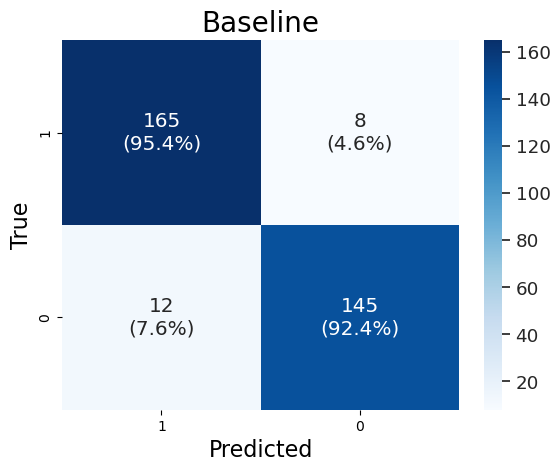

In [ ]:
# Baseline 모델 혼동행렬
cm = confusion_matrix(df['True'], df['Base_bin'], labels = [1, 0])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

# 정수값 + 비율 표시
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"

ax = plt.subplot()
sns.set(font_scale=1.2) # Adjust to fit
sns.heatmap(cm,
            annot=annot,
            fmt='',
            cmap='Blues')

plt.title("Baseline", fontsize = 20)
plt.xlabel("Predicted", fontsize = 16)
plt.ylabel("True", fontsize = 16)
plt.xticks([0.5,1.5],["1","0"])
plt.yticks([0.5,1.5],["1","0"])
plt.savefig("fig/confusion_Baseline.png", dpi = 300)

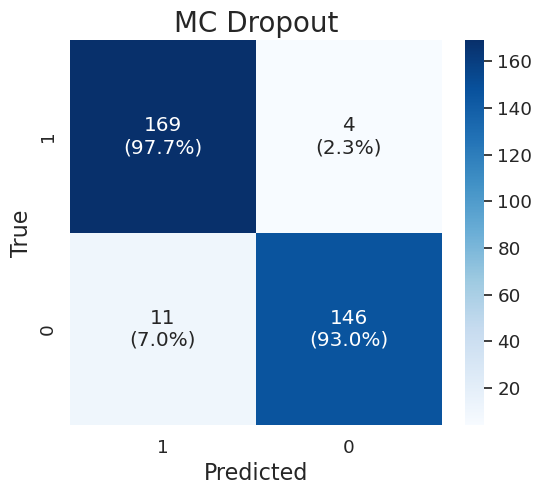

In [ ]:
# MC Dropout 혼동행렬
cm = confusion_matrix(df['True'], df['MC_bin'], labels = [1, 0])
cm_norm = cm / cm.sum(axis=1, keepdims=True)

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"

plt.figure(figsize=(6,5))
sns.set(font_scale=1.2) # Adjust to fit
sns.heatmap(cm,
            annot=annot,
            fmt='',
            cmap='Blues')

plt.title("MC Dropout", fontsize = 20)
plt.xlabel("Predicted", fontsize = 16)
plt.ylabel("True", fontsize = 16)
plt.xticks([0.5,1.5],["1","0"])
plt.yticks([0.5,1.5],["1","0"])
plt.savefig("fig/confusion_MC.png", dpi = 300)

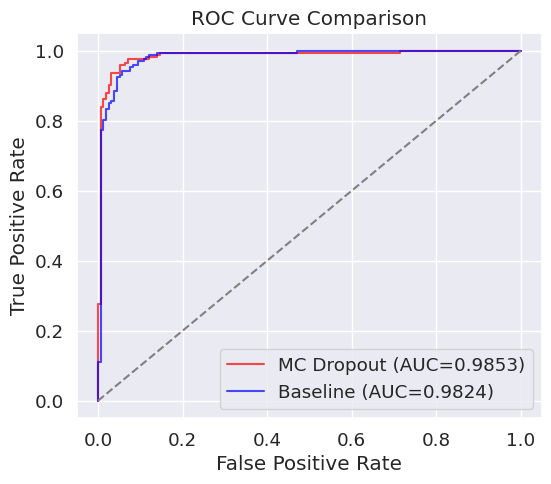

In [ ]:
fpr_base, tpr_base, _ = roc_curve(df['True'], df['Pred'])
fpr_mc, tpr_mc, _ = roc_curve(df['True'], df['MC_Pred'])

auc_base = auc(fpr_base, tpr_base)
auc_mc = auc(fpr_mc, tpr_mc)

plt.figure(figsize=(6,5))
plt.plot(fpr_mc, tpr_mc, label=f'MC Dropout (AUC={auc_mc:.4f})', color='red', alpha = 0.7)
plt.plot(fpr_base, tpr_base, label=f'Baseline (AUC={auc_base:.4f})', color='blue', alpha = 0.7)
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.savefig("fig/ROC.png", dpi = 300)

`-` MC dropout 틀린 이미지 출력

In [24]:
df_incorrect = df_mc.loc[(df_mc.Pred > 0.5) != df_mc["True"]].reset_index()
df_incorrect

,index,True,Pred
0,14,1,0.129668
1,44,0,0.536357
2,46,1,0.002525
3,57,0,0.813770
4,75,0,0.592673
5,82,0,0.760709
6,154,0,0.858169
7,159,0,0.606690
8,165,0,0.671521
9,186,1,0.247309


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0124188e-08..0.99607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0124188e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0124188e-08..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0124188e-08..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0124188e-08..0.99999994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.0124188e-08..0.9882353].


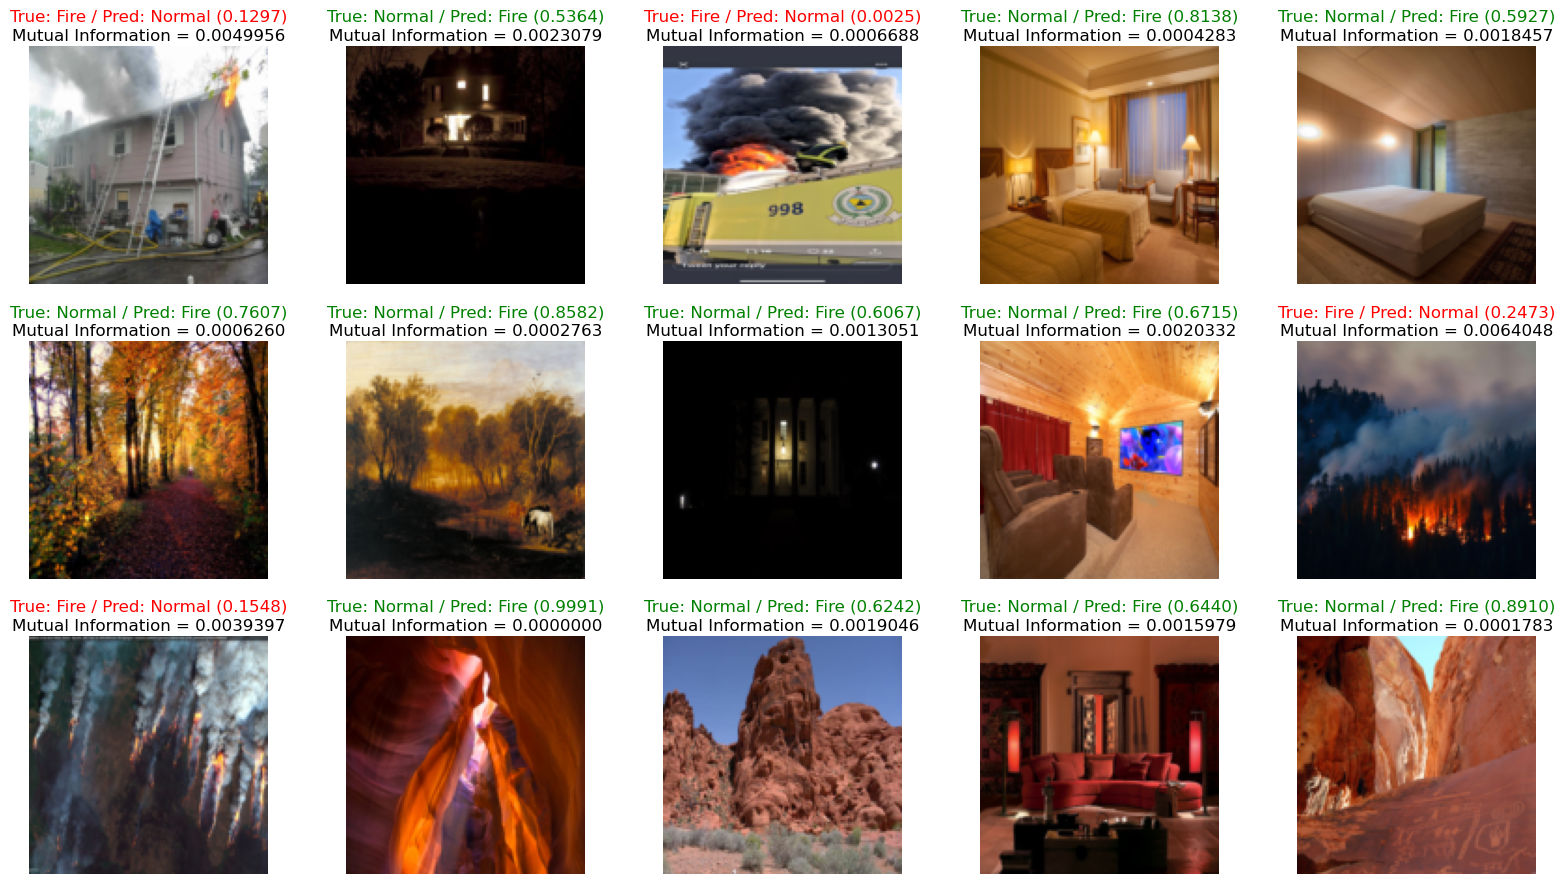

In [37]:
mean = [0.4420, 0.3569, 0.2830]
std = [0.2781, 0.2527, 0.2595]

inv_normalize = transforms.Normalize(
   mean = [-m/s for m, s in zip(mean, std)],
   std = [1/s for s in std]
)

fig, ax = plt.subplots(3, 5, figsize = (16, 9))
idxs = df_incorrect["index"]
idx = 0
title_label = ["Normal", "Fire"]

for i in range(3):
    for j in range(5):
        current_img = test_ds[idxs[idx]]
        ax[i][j].imshow(inv_normalize(current_img[0]).permute(1, 2, 0))
        ax[i][j].text(0.5, 1.1, f"True: {title_label[current_img[1]]} / Pred: {'Fire' if df_incorrect["Pred"][idx] > 0.5 else 'Normal'} ({df_incorrect["Pred"][idx]:.4f})",
                      ha = "center", fontsize = 12, transform=ax[i][j].transAxes,
                      color = "red" if title_label[current_img[1]] == "Fire" else "green")
        ax[i][j].text(0.5, 1.02, f"Mutual Information = {MI[idxs[idx]]:.7f}",
                      ha = "center", fontsize = 12, transform=ax[i][j].transAxes)
        ax[i][j].axis("off")
        idx += 1

plt.tight_layout()
plt.savefig("fig/incorrect.png", dpi = 300)